In [3]:
import numpy as np
import pandas as pd 
from sklearn import preprocessing, model_selection, linear_model, ensemble, metrics
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import math

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

import itertools

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### EDA

In [4]:
train = pd.read_json("train.json")
test = pd.read_json("test.json")

In [23]:
train.head(3)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,medium
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue,low
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street,high


In [24]:
test.head(3)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address
0,1.0,1,79780be1514f645d7e6be99a3de696c5,2016-06-11 05:29:41,Large with awesome terrace--accessible via bed...,Suffolk Street,"[Elevator, Laundry in Building, Laundry in Uni...",40.7185,7142618,-73.9865,b1b1852c416d78d7765d746cb1b8921f,[https://photos.renthop.com/2/7142618_1c45a2c8...,2950,99 Suffolk Street
1,1.0,2,0,2016-06-24 06:36:34,Prime Soho - between Bleecker and Houston - Ne...,Thompson Street,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7278,7210040,-74.0000,d0b5648017832b2427eeb9956d966a14,[https://photos.renthop.com/2/7210040_d824cc71...,2850,176 Thompson Street
100,1.0,1,3dbbb69fd52e0d25131aa1cd459c87eb,2016-06-03 04:29:40,New York chic has reached a new level ...,101 East 10th Street,"[Doorman, Elevator, No Fee]",40.7306,7103890,-73.9890,9ca6f3baa475c37a3b3521a394d65467,[https://photos.renthop.com/2/7103890_85b33077...,3758,101 East 10th Street


In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49352 entries, 10 to 99994
Data columns (total 15 columns):
bathrooms          49352 non-null float64
bedrooms           49352 non-null int64
building_id        49352 non-null object
created            49352 non-null object
description        49352 non-null object
display_address    49352 non-null object
features           49352 non-null object
latitude           49352 non-null float64
listing_id         49352 non-null int64
longitude          49352 non-null float64
manager_id         49352 non-null object
photos             49352 non-null object
price              49352 non-null int64
street_address     49352 non-null object
interest_level     49352 non-null object
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB


In [26]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74659 entries, 0 to 99999
Data columns (total 14 columns):
bathrooms          74659 non-null float64
bedrooms           74659 non-null int64
building_id        74659 non-null object
created            74659 non-null object
description        74659 non-null object
display_address    74659 non-null object
features           74659 non-null object
latitude           74659 non-null float64
listing_id         74659 non-null int64
longitude          74659 non-null float64
manager_id         74659 non-null object
photos             74659 non-null object
price              74659 non-null int64
street_address     74659 non-null object
dtypes: float64(3), int64(3), object(8)
memory usage: 8.5+ MB


In [40]:
train['interest_level'].value_counts()

low       34284
medium    11229
high       3839
Name: interest_level, dtype: int64

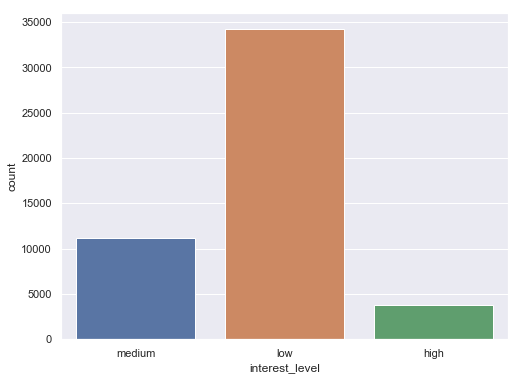

In [83]:
plt.figure(figsize=(8,6))
sns.countplot(x='interest_level', data=train)

#### Классы не сбалансированы.

#### Присутствуют признаки категориальные, вещественные, текстовые , временные , ссылки на изображения.
#### Пропусков нет. Разделим на признаки.

In [39]:
cat_cols = list(train.select_dtypes(include=['object']).drop(['created', 'description', 'features', 'photos'], axis=1).columns)
num_cols = list(train.select_dtypes(exclude=['object']).columns)
txt_cols = ['description', 'features']
date_cols =['created']

#### Посмотрим статистику

In [42]:
train[num_cols].describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,49352.00000,49352.000000,49352.000000,4.935200e+04,49352.000000,4.935200e+04
mean,1.21218,1.541640,40.741545,7.024055e+06,-73.955716,3.830174e+03
std,0.50142,1.115018,0.638535,1.262746e+05,1.177912,2.206687e+04
min,0.00000,0.000000,0.000000,6.811957e+06,-118.271000,4.300000e+01
25%,1.00000,1.000000,40.728300,6.915888e+06,-73.991700,2.500000e+03
50%,1.00000,1.000000,40.751800,7.021070e+06,-73.977900,3.150000e+03
75%,1.00000,2.000000,40.774300,7.128733e+06,-73.954800,4.100000e+03
max,10.00000,8.000000,44.883500,7.753784e+06,0.000000,4.490000e+06


In [44]:
test[num_cols].describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,74659.000000,74659.000000,74659.000000,7.465900e+04,74659.000000,7.465900e+04
mean,1.212915,1.544663,40.735060,7.024001e+06,-73.945282,3.749033e+03
std,0.649820,1.107014,0.806687,1.264496e+05,1.487795,9.713092e+03
min,0.000000,0.000000,0.000000,6.811958e+06,-121.488000,1.000000e+00
25%,1.000000,1.000000,40.727800,6.915516e+06,-73.991800,2.495000e+03
50%,1.000000,1.000000,40.751600,7.021738e+06,-73.977700,3.150000e+03
75%,1.000000,2.000000,40.774300,7.129166e+06,-73.954700,4.100000e+03
max,112.000000,7.000000,42.872700,7.761779e+06,0.000000,1.675000e+06


In [ ]:
plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[0])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('bathrooms', fontsize=12)

#### По некоторым признакам есть выбросы - bathrooms , price.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000002F18B780>,
      dtype=object)

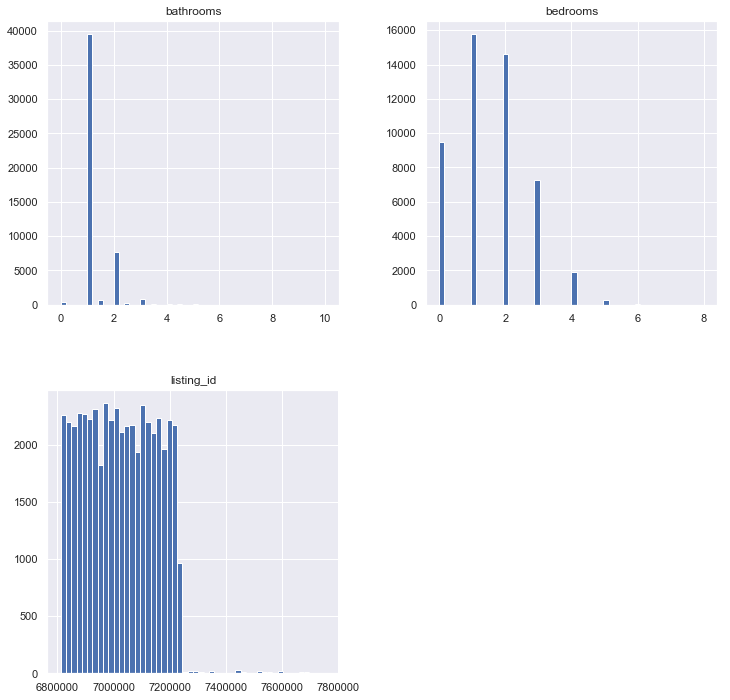

In [52]:
train[['bathrooms', 'bedrooms', 'listing_id']].hist(figsize=(12, 12), bins=50)

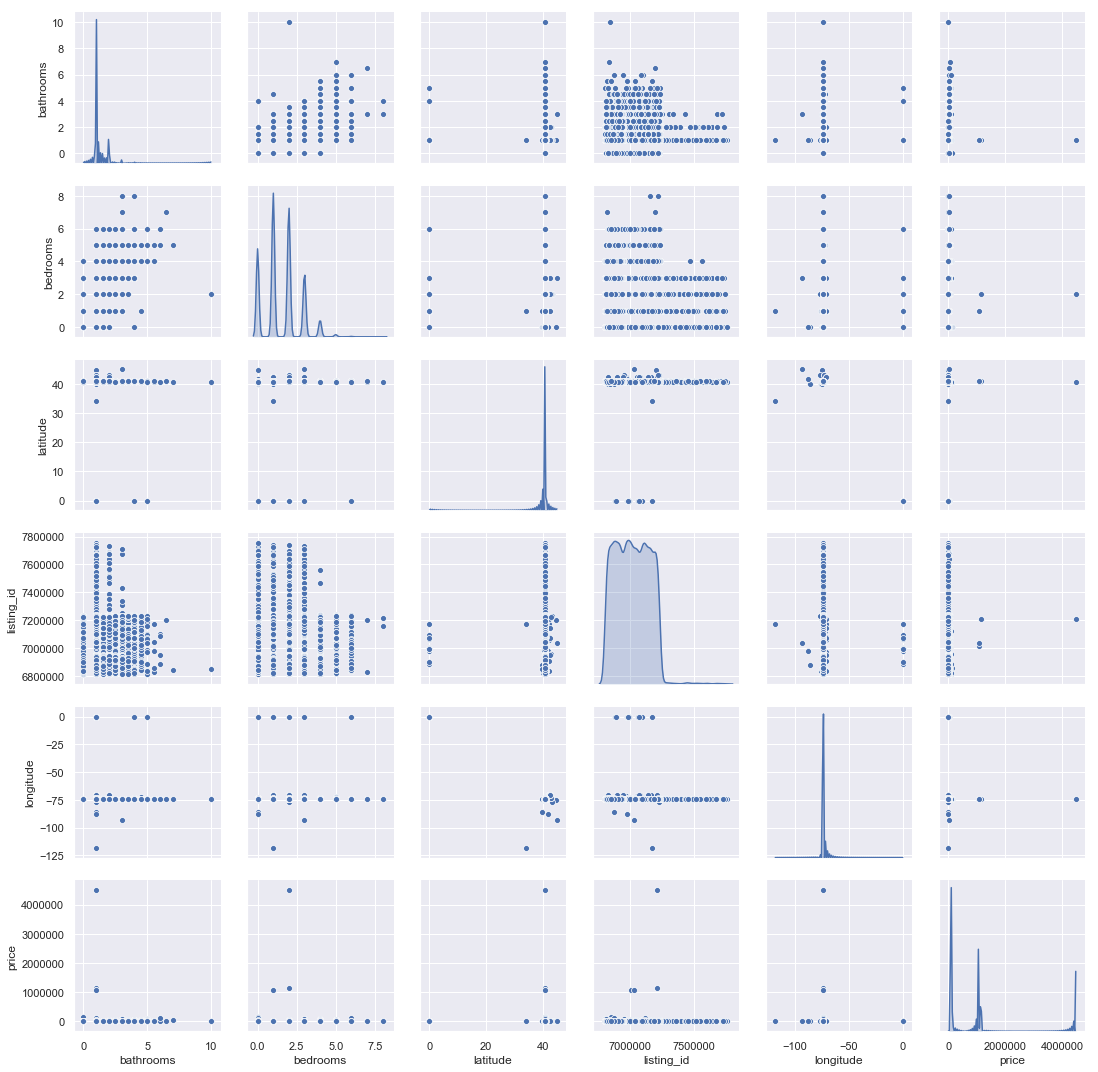

In [57]:
sns.pairplot(train[num_cols], diag_kind="kde")

#### Среди числовых признаков нет константных, но есть такие, у которых доминирует одно значение
#### Для таких признаков имеет смысл создавать дополнительные бинарные переменные, 
#### показывающие, равно ли значение признака доминирующему. 
#### Но в дальнейшем этот вид feature engineering не дал ощутимых результатов.

#### Рассмотрим ближе признаки

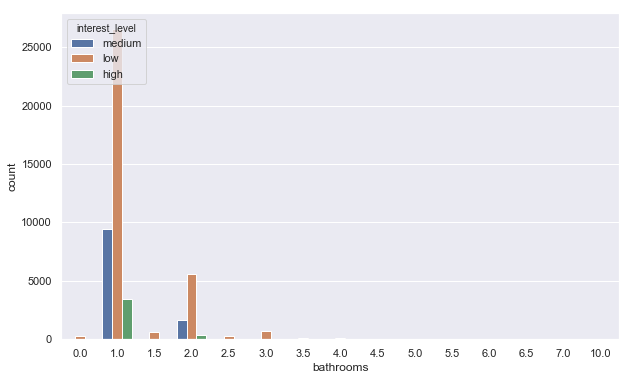

In [64]:
plt.figure(figsize=(10,6))
sns.countplot(x='bathrooms', hue='interest_level', data=train)

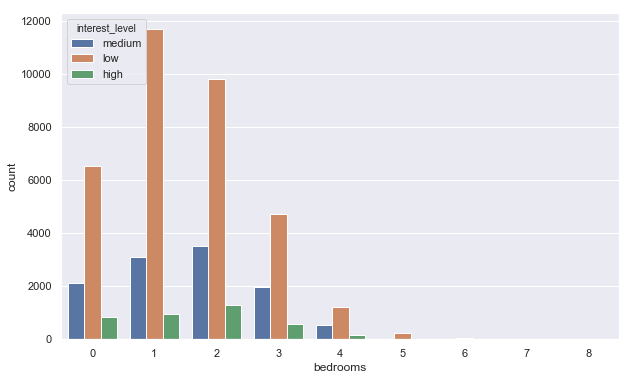

In [63]:
plt.figure(figsize=(10,6))
sns.countplot(x='bedrooms', hue='interest_level', data=train)

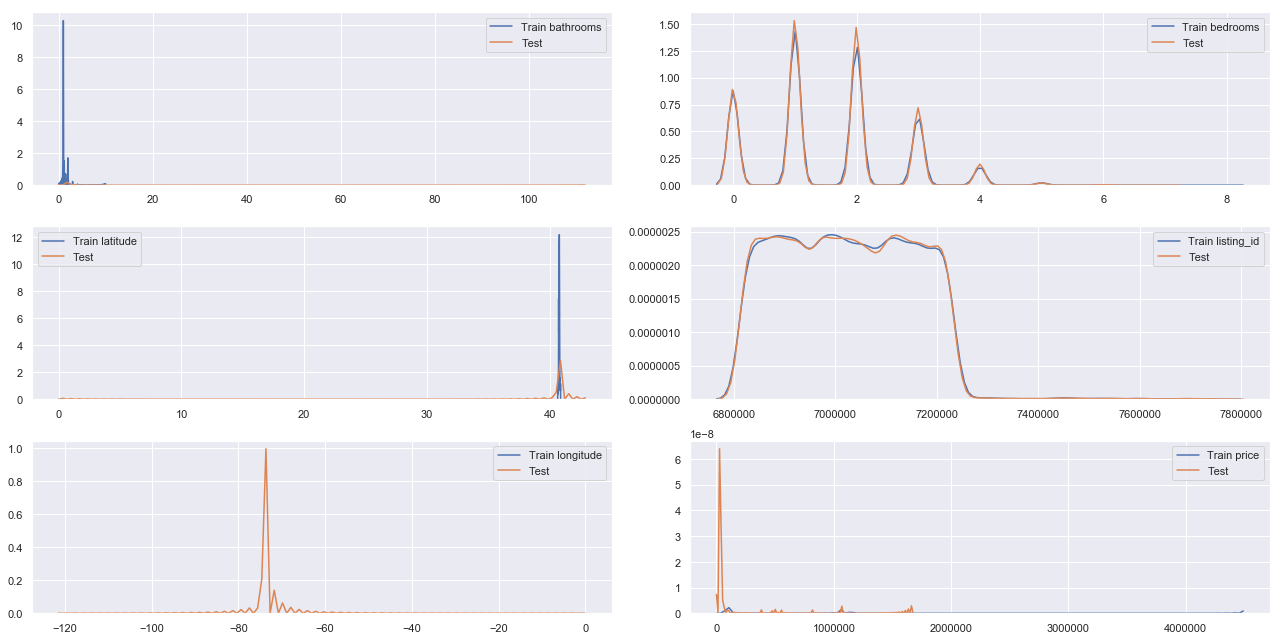

In [79]:
fig, axes = plt.subplots(3,2, figsize=(18, 9))

index = list(itertools.product(range(3),range(2)))
for i in range(len(num_cols)):
    
    axx = sns.kdeplot(train[num_cols[i]], ax=axes[index[i][0],index[i][1]], label="Train" + " "+num_cols[i])
    sns.kdeplot(test[num_cols[i]], ax=axes[index[i][0],index[i][1]], label="Test")
    
        
fig.tight_layout()

#### Видим, что распределение данных по некоторым признакам  в обучениии и тесте различаются.
#### Модель, обученная по этим признакам , вероятно будет плохо работать  на новых (тестовых) данных.

#### Посмотрим корреляцию признаков

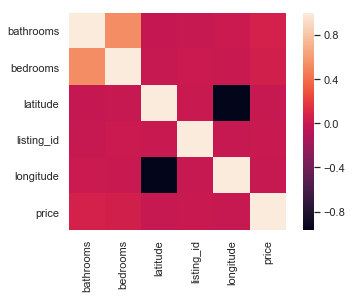

In [59]:
sns.heatmap(train[num_cols+['interest_level']].corr(), square=True)

### Построение модели.

In [1]:
def Add_TXT_Features(df_train_txt, df_test_txt, df_train, df_test, feature_txt=None, ncomponents=2, randomstate=None ):
  """
  Extract and add features from txt.
  """
  vect = TfidfVectorizer(sublinear_tf=True, use_idf=True)
  train_txt = vect.fit_transform(df_train_txt[feature_txt].values)
  test_txt = vect.transform(df_test_txt[feature_txt].values)
  
  tsvd = TruncatedSVD(n_components=ncomponents, random_state=randomstate)
  train_txt_pca = tsvd.fit_transform(train_txt)
  test_txt_pca = tsvd.transform(test_txt)

  Xtrain = pd.concat([df_train, pd.DataFrame(train_txt_pca)], ignore_index=True, axis=1)
  Xtest = pd.concat([df_test, pd.DataFrame(test_txt_pca)], ignore_index=True, axis=1)
  
  return Xtrain, Xtest

In [5]:
train = train.reset_index().drop(['index'], axis=1)
test = test.reset_index().drop(['index'], axis=1)

In [6]:
train_labels = train['interest_level']
le = preprocessing.LabelEncoder()
train_labels_enc = pd.DataFrame(le.fit_transform(train_labels))

In [7]:
X_train = train.drop(['created', 'description', 'features', 'photos', 'interest_level', 'street_address'], axis=1)
X_test = test.drop(['created', 'description', 'features', 'photos', 'street_address'], axis=1)

#### feature engineering  который не дал ощутимых результатов.

In [ ]:
X_train['F1'] = X_train['bathrooms'].apply(lambda x: 1 if math.modf(x)[0]==0 else 0)
X_test['F1'] = X_test['bathrooms'].apply(lambda x: 1 if math.modf(x)[0]==0 else 0)

In [ ]:
X_train['F2'] = X_train['bathrooms'].apply(lambda x: 1 if x==1.0 else 0)
X_test['F2'] = X_test['bathrooms'].apply(lambda x: 1 if x==1.0 else 0)

In [ ]:
X_train['F3'] = X_train['building_id'].apply(lambda x: 1 if x==str('0') else 0)
X_test['F3'] = X_test['building_id'].apply(lambda x: 1 if x==str('0') else 0)

In [ ]:
X_train['F4'] = X_train['price'].apply(lambda x: np.log1p(x+1))
X_test['F4'] = X_test['price'].apply(lambda x: np.log1p(x+1))

In [8]:
#label encoding
Data = pd.concat([X_train, X_test], ignore_index=True)
for c in Data.columns[Data.dtypes == 'object']:
    Data[c] = Data[c].factorize()[0]

X_train = pd.DataFrame(Data).iloc[0:X_train.shape[0],:]
X_test = pd.DataFrame(Data).iloc[X_train.shape[0]:, :].reset_index()
X_test = X_test.drop(['index'], axis=1)

In [9]:
#Add feture from txt
train_txt = pd.DataFrame(train[['features']]['features'].apply(lambda x: 'Nothing' if x==[] else ' '.join(x)))
test_txt = pd.DataFrame(test[['features']]['features'].apply(lambda x: 'Nothing' if len(x)==0 else ' '.join(x)))

X_train, X_test = Add_TXT_Features(train_txt, test_txt, X_train, X_test, feature_txt='features', 
                                   ncomponents=16, randomstate=123 )

In [10]:
#Add feture from txt
train_txt = train[['description']]
test_txt = test[['description']]

X_train, X_test = Add_TXT_Features(train_txt, test_txt, X_train, X_test, feature_txt='description', 
                                   ncomponents=50, randomstate=123 )

In [ ]:
xgb = XGBClassifier(max_depth=5, n_estimators=400, random_state=1)
cv = model_selection.StratifiedKFold(n_splits=4 , shuffle=True, random_state=123)
score = model_selection.cross_val_score(xgb, X_train, y=train_labels_enc, scoring='neg_log_loss', cv=cv)
print(-1*score.mean())

xgb.fit(X_train, train_labels_enc)
y_predicted_proba = xgb.predict_proba(X_test)

predicted_proba = pd.DataFrame(y_predicted_proba, columns=['high','low', 'medium'])[['high', 'medium', 'low']]
listing_id = test[['listing_id']].reset_index().drop(['index'], axis = 1)
Submit = pd.concat((listing_id, predicted_proba),axis=1)
Submit.to_csv('Submit_.csv', index=False)

In [ ]:
"""
Результат по этому pipeline на  Private Score - 0.57616.

Дальнейшие пути улучшения. 
Извлечение признаков из фото.
Фича инж. с координатами.
Стэкинг моделей. XGboost + kNN + RF + NNet.

"""